# Quantum Graph Hamiltonian Neural Networks (QGHNN)

This work is based on the Quantum Graph Hamiltonian Neural Network (QGHNN) model introduced by W. Wang (QGHNN, 2025), which proposes a physics‑driven approach to learning on graph‑structured data. The key idea is to encode the topology of a classical graph directly into Hamiltonian dynamics, allowing a quantum system to learn graph structure through variational evolution.

In this notebook, we reproduce the QGHNN architecture and implement the full training workflow using the Qiskit Patterns methodology. The contribution of this thesis lies in the practical realization of QGHNN within the Qiskit framework, the reproduction of its training behavior, and the analysis of its performance on simulators.

## Quantum Graph Hamiltonian Learning (QGHL)

Quantum Graph Hamiltonian Learning (QGHL) as described by W. Wang (QGHNN, 2025) is a method that maps a graph $G = (V, A)$ into a quantum state $|\psi\rangle$ by learning a *mapping Hamiltonian* $\mathcal{H}_m$ associated with the graph. The goal is to encode the adjacency structure of the classical graph into the quantum state, such that the resulting state reflects the graph's structure. This is done by evolving an initial state on a lattice with periodic boundary conditions, so that the final quantum state captures adjacency information of the graph.



Given adjacency matrix elements $A_{ij}$, the graph is mapped to a topological Hamiltonian:

$$
\mathcal{H}_m = \sum_{i,j\in V} A_{ij}\left(
J_x\,X_{i}X_{j} +
J_y\,Y_{i}Y_{j} +
J_z\,Z_{i}Z_{j}
\right)
$$

where $X,Y,Z$ are Pauli operators and $J_x, J_y, J_z$ are coupling constants. This expresses the structure of the graph as a physical spin-interaction Hamiltonian.

The QGHL model constructs its quantum circuit directly from a Hamiltonian, making it fundamentally a physics-native neural network layer. The architecture emerges from physical time evolution under a circuit Hamiltonian. The unitary operator used in the variational ansatz is derived from:

$$
U(\theta) = \exp\!\left(-\frac{i}{\hbar}\,\theta\,\mathcal{H}_c\right),
$$

where $\mathcal{H}_c$ is the circuit Hamiltonian:

$$
\mathcal{H}_c =
\sum_{n=1}^{N} Y_{n}
+
\sum_{n=1}^{N}\left(
\frac{1}{2}I - \frac{\pi}{4}\, Z_{n}\otimes Z_{n+1}
\right)
+
\sum_{n=1}^{N} X_{n}.
$$

We substitute $\mathcal{H}_c$ into the exponential of the time evolution operator:

$$
U(\theta) =
\exp\!\left(
-i\theta
\left[
\sum_{n=1}^{N} Y_n
+
\sum_{n=1}^{N}
\left(
\frac{1}{2}I
-\frac{\pi}{4} Z_n \otimes Z_{n+1}
\right)
+
\sum_{n=1}^{N} X_n
\right]
\right).
$$
where $\hbar = 1$ (working on natural units).    
Using a first-order Suzuki–Trotter approximation for non-commuting operators, the expression factorizes as

$$
U(\theta)
\approx
\exp\!\left(-i\theta\sum_{n=1}^{N} Y_n\right)
\exp\!\left(-i\theta\sum_{n=1}^{N}\frac{I}{2}\right)
\exp\!\left(\frac{i\pi\theta}{4}\sum_{n=1}^{N} Z_n\otimes Z_{n+1}\right)
\exp\!\left(-i\theta\sum_{n=1}^{N} X_n\right).
$$

Rewriting each exponential as a product over qubits, we end up with:

$$
\large
U(\theta) =
\prod_{n=1}^{N} e^{-i\theta Y_n}\;
\prod_{n=1}^{N} e^{-i\theta I/2}\;
\prod_{n=1}^{N} e^{i\pi\theta Z_n Z_{n+1}/4}\;
\prod_{n=1}^{N} e^{-i\theta X_n}.
$$

The factor involving the identity operator contributes only a global phase and is therefore omitted in the circuit implementation. The two‑qubit interaction term admits the standard decomposition:

$$
e^{i\pi\theta\,Z_n Z_{n+1}/4} =
\mathrm{CNOT}_{n\to n+1}\;
R_z\!\left(\tfrac{2}{\pi}\theta\right)\;
\mathrm{CNOT}_{n\to n+1}.
$$

Thus one variational layer is:

$$
U(\theta) =
R_y(\theta)\;
\mathrm{CNOT}\;
R_z\!\left(\tfrac{2}{\pi}\theta\right)\;
\mathrm{CNOT}\;
R_x(\theta),
$$

This is the building block used for all qubits and all layers. Each “quantum neuron” is a variational unitary layer $U(\theta)$.   


The *QGHL* method updates the parameters of the quantum circuit using a *gradient descent optimization*. Specifically, it minimizes the *loss function* defined as:

$$
Loss(\theta) = \langle \psi_t(\theta) | \mathcal{H}_m | \psi_t(\theta) \rangle
$$

where $|\psi_t(\theta)\rangle$ is the intermediate quantum state produced by the circuit and $\mathcal{H}_m$ is the Hamiltonian representing the graph structure.  

During training, the algorithm also monitors the *Gap*:

$$
Gap = | Loss(\theta) - E_0 |
$$

that is defined as the the difference between the expectation vlaue of the mapping Hamiltonian on the current circuit and the true ground state energy or the minimum eigenvalue of the mapping Hamiltonian $\mathcal{H}_m$.  

- If the *Gap* exceeds a small threshold $\delta$, the parameters $\theta$ are updated to reduce the loss.  
- If the *Gap* is smaller than $\delta$, the circuit is considered to have successfully encoded the graph into the quantum state, producing the final output state $|\psi_{\text{out}}\rangle$.  

In this way, *QGHL* maps the graph $G$ into a quantum state by learning the topological Hamiltonian $\mathcal{H}_m$ through variational optimization.

# A Quantum Graph Hamiltonian Neural Network using Qiskit Patterns

We adopt the Qiskit Patterns methodology to implement a full QGHNN workflow. Beginning with the mapping of a graph to a quantum circuit, we progress through hardware-aware optimization, execution on simulators or quantum processors, and post-processing of measurement results. This structured approach provides a clear blueprint for deploying Hamiltonian-based graph learning models on quantum hardware.

## Qiskit Patterns Step 1: Map the Problem to a Quantum Circuit

The goal of the *Quantum Graph Hamiltonian Neural Network (QGHNN)* is to find a parameterized functional $f(\theta)$ with trainable parameters $\theta$ that maps a graph $G=(V,A)$ into a quantum state. The evolved quantum state $|\psi_t(\theta)\rangle = U(\theta) | \psi_{\text{in}} \rangle$ should capture the graph's structural properties as encoded in the topological Hamiltonian $\mathcal{H}_m$.

The objective functional is:

$$
f(\theta) = \langle\psi_{\text{in}}|U^\dagger(\theta) \mathcal{H}_m U(\theta)|\psi_{\text{in}}\rangle
= \langle\psi_t(\theta)|\mathcal{H}_m|\psi_t(\theta)\rangle = Loss(\theta)
$$

where $|\psi_{\text{in}}\rangle$ is the input quantum state obtained by amplitude encoding the normalized adjacency matrix $A_{ij}$, $U(\theta)$ is the variational quantum circuit (ansatz) composed of $L$ layers of trainable neuron/unitary operations, and $\mathcal{H}_m$ is the graph Hamiltonian, defined as a weighted sum of Pauli operators according to the adjacency matrix.

We start with visualizing the graph and it's adjecent matrix

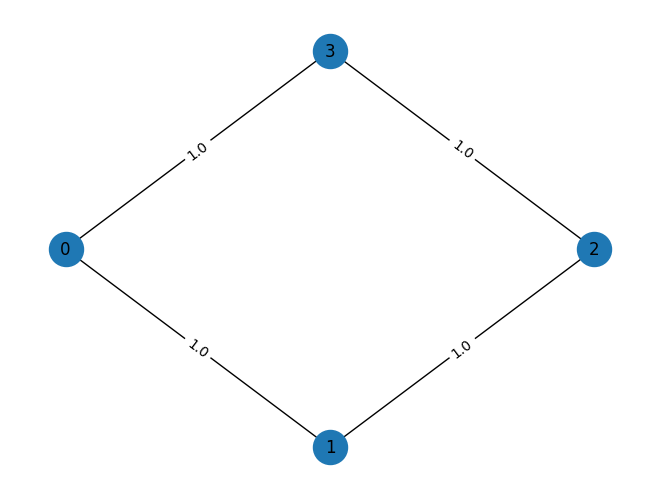

Adjacency Matrix:
 [[0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]]


In [11]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw
import matplotlib.pyplot as plt

n = 4
G = rx.PyGraph()
G.add_nodes_from(range(n))
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_edges_from(edges)

mpl_draw(
    G, pos=rx.shell_layout(G), with_labels=True, edge_labels=str, node_size=600
)

plt.show()

A = rx.adjacency_matrix(G)
print("Adjacency Matrix:\n", A)

Before encoding, the adjacency matrix elements must satisfy the *normalization condition*. The normalized adjacency matrix $A'_{ij}$ is defined as:

$$
A'_{ij} = \frac{A_{ij}}{\sqrt{\sum_{i,j} A_{ij}^2}}
$$

This ensures that the total probability amplitude of the quantum state sums to 1.  

In [14]:
import numpy as np

A = np.array(A, dtype=float)

# Flatten adjacency matrix - converts the 2D matrix into a 1D array (vector)
A_flat = A.flatten()
print("Flatten Adjacency Matrix:\n", A_flat)

# Normalization
A_norm = A_flat / np.linalg.norm(A_flat)
print("Normalized Adjacency Matrix:\n", A_norm)

Flatten Adjacency Matrix:
 [0. 1. 0. 1. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0.]
Normalized Adjacency Matrix:
 [0.         0.35355339 0.         0.35355339 0.35355339 0.
 0.35355339 0.         0.         0.35355339 0.         0.35355339
 0.35355339 0.         0.35355339 0.        ]


### Amplitude Encoding

For a graph $G = (V, A_{ij})$ with $4 \times 4$ adjacency matrix, the input quantum state $|\psi_{in}\rangle$ of the QGHNN is constructed by mapping the normalized elements $A'_{ij}$ to the amplitudes of the quantum state:

$$
|\psi_{in}\rangle = \sum_{i,j} A'_{ij} \, |i\rangle|j\rangle
$$

This prepares the quantum system so that the graph information is fully encoded in the amplitudes of the initial state.

Number of qubits needed: 4
Qubits: [0, 1, 2, 3]


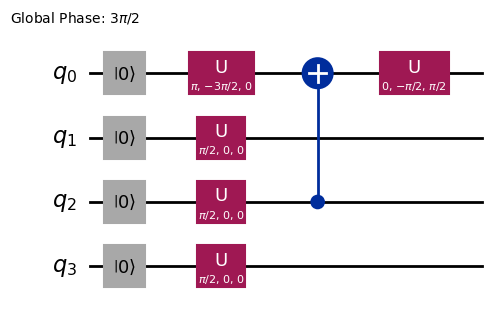

In [35]:
from qiskit import QuantumCircuit

# Compute required qubits
qubits = int(np.ceil(np.log2(len(A_flat))))
print("Number of qubits needed:", qubits)

# Qubit indices
qubit_numbers = list(range(qubits))
print("Qubits:", qubit_numbers)

# Initialize quantum circuit
qc = QuantumCircuit(qubits)
qc.initialize(A_norm, qubit_numbers)
qc.decompose(reps=5).draw(fold=False, output="mpl")

### The QGHNN Ansatz

The ansatz $U(\theta)$ is a variational quantum circuit, composed of $L$ layers of trainable unitaries. Each layer implements a “neuron” unit acting on neighbour qubit pairs $(i,j)$ corresponding to graph edges:

$$
U_{\text{layer}}(\theta_l) = \prod_{(i,j)\in E}
\Big(\bigl(R_y(\theta_{l,0}) \otimes R_y(\theta_{l,0})\bigr)\,
\mathrm{CNOT}_{i\to j}\,
\bigl(I \otimes R_z(\tfrac{2}{\pi}\,\theta_{l,1})\bigr)\,
\mathrm{CNOT}_{i\to j}\,
\bigl(R_x(\theta_{l,2}) \otimes R_x(\theta_{l,2})\bigr)\Big).
$$

Each layer $l$ has its own set of 3 tunable parameters $\theta_l = (\theta_{l,0}, \theta_{l,1}, \theta_{l,2})$ - within a layer all qubits in the same gate class use the same parameter, while different layers have different parameters.

<center>
    <img src="neuron_unitary.png" width="800">
</center>

Depth:  64
2+ qubit depth: 29


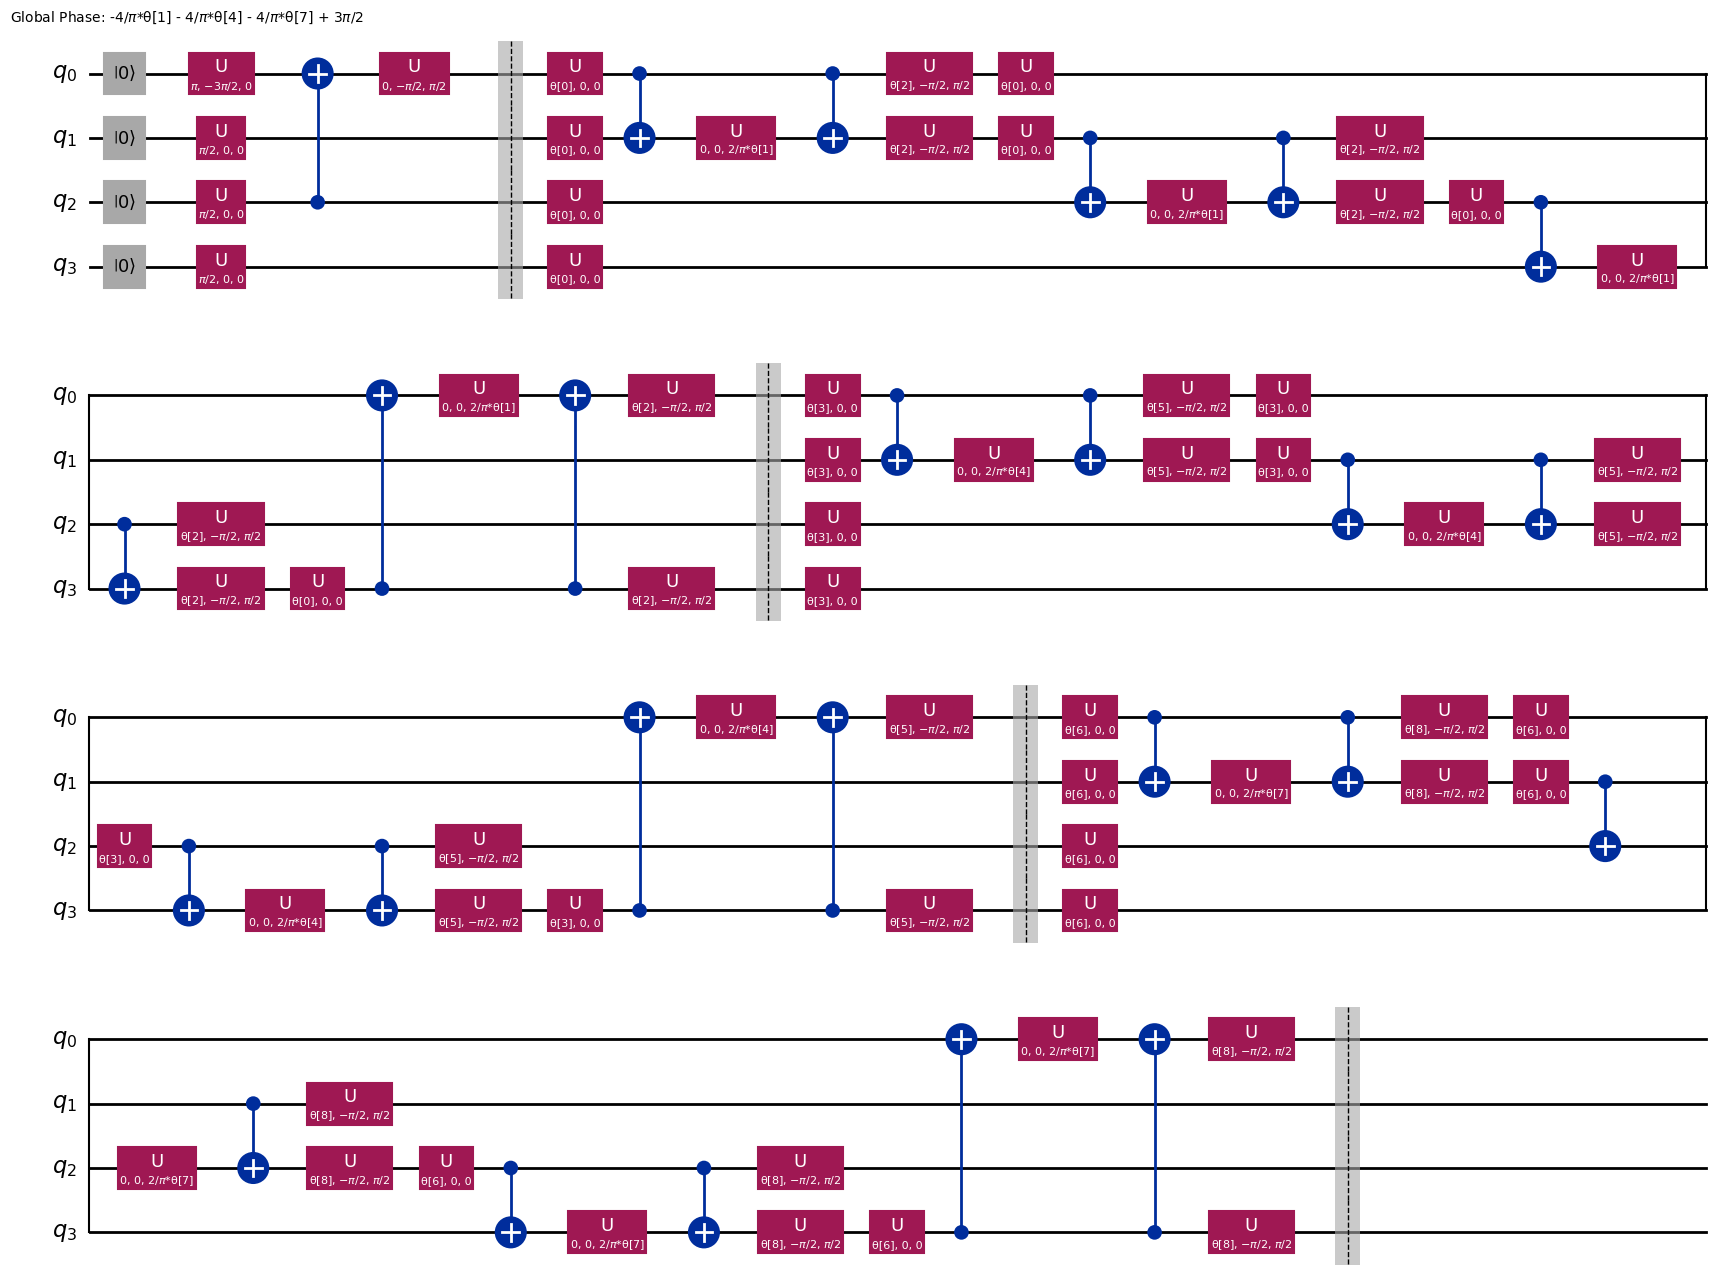

In [46]:
from qiskit.circuit import ParameterVector

# Nearest‑neighbor pairs along the qubit chain
edges_list = [(0, 1), (1, 2), (2, 3), (3,0)]
n_qubits = 4
L = 3  # number of layers

# Parameter vector: 3 parameters per layer (Ry, Rz, Rx)
theta = ParameterVector("θ", length=3 * L)

# Initialize circuit with amplitude encoding
qghnn_circuit = QuantumCircuit(n_qubits)
qghnn_circuit.initialize(A_norm, range(n_qubits)) 
qghnn_circuit.barrier()

# Implement a single “neuron", which is a trainable unitary acting on a pair of neighbour qubits (q0, q1).
def neuron_unit(qc, q0, q1, theta_layer):
    """
    Implements a QGHNN neuron/unitary:
    U(θ) = Ry(θ) · CNOT · Rz((2/π)θ) · CNOT · Rx(θ)
    Same parameters shared among qubits for each gate class.
    """
    qc.ry(theta_layer[0], q0)
    qc.ry(theta_layer[0], q1)
    
    qc.cx(q0, q1)

    qc.rz(2/np.pi * theta_layer[1], q1)
    
    qc.cx(q0, q1)
    
    qc.rx(theta_layer[2], q0)
    qc.rx(theta_layer[2], q1)

# Repeats the neuron/unitary across multiple layers to increase the expressivity of the variational circuit.
for l in range(L):
    theta_layer = theta[3*l : 3*l+3]
    for q0, q1 in edges_list:
        neuron_unit(qghnn_circuit, q0, q1, theta_layer)
    qghnn_circuit.barrier()

# Check the circuit depth, and the two-qubit gate depth
print("Depth: ", qghnn_circuit.decompose(reps=5).depth())
print(
    f"2+ qubit depth: {qghnn_circuit.decompose(reps=5).depth(lambda instr: len(instr.qubits) > 1)}"
)

qghnn_circuit.decompose(reps=5).draw(output="mpl")

In [7]:
# Build a parameterized QGHNN circuit fucntion
def build_qghnn_circuit(A_norm, n_qubits, edges_list, L):
    theta_params = ParameterVector("θ", length=3 * L)
    qc = QuantumCircuit(n_qubits)
    qc.initialize(A_norm, range(n_qubits))
    qc.barrier()
    for l in range(L):
        theta_layer = theta_params[3*l : 3*l+3]
        for q0, q1 in edges_list:
            neuron_unit(qc, q0, q1, theta_layer)
        qc.barrier()
    return qc, theta_params

### Building the Mapping Hamiltonian

The mapping  Hamiltonian $\mathcal{H}_m$, which encodes the structure of the graph $G = (V, A_{ij})$, is defined as a sum of Pauli operator products weighted by the adjacency matrix.

$$
\mathcal{H}_m = \sum_{i,j\in V} A_{ij}\left(
J_x\,X_{i}X_{j} +
J_y\,Y_{i}Y_{j} +
J_z\,Z_{i}Z_{j}
\right)
$$

where $A_{ij}$ are the adjacency matrix elements, $J_x,J_y,J_z$ are spin-coupling constants and $X,Y,Z$ are Pauli operators acting on qubit $i$.   
The Hamiltonian sums over all pairs of nodes $(i,j)$ and applies two-qubit interactions along $X$, $Y$, and $Z$ axes according to the adjacency matrix.  

In other words:

- $\mathcal{H}_m$ is the *graph Hamiltonian*, the objective we want to match.
- $\mathcal{H}_c$ is the *circuit Hamiltonian*, implemented by the variational quantum gates.
- Training updates the parameters $\theta$ in $U(\theta)$ so that the evolved state under $\mathcal{H}_c$ encodes the graph structure defined by $\mathcal{H}_m$.

In [9]:
from qiskit.quantum_info import SparsePauliOp, Pauli

def graph_hamiltonian(A, Jx=1.0, Jy=1.0, Jz=1.0):
    """
    Constructs the mapping Hamiltonian Hm for a given adjacency matrix A.
    Hm = Σ_{i<j} A_ij * (Jx*X_i X_j + Jy*Y_i Y_j + Jz*Z_i Z_j)
    
    Args:
        A (ndarray): adjacency matrix of size n x n
        Jx, Jy, Jz (float): coupling constants (default 1.0)
    
    Returns:
        SparsePauliOp: the Hamiltonian operator
    """
    n = A.shape[0]
    paulis = []
    coeffs = []

    for i in range(n):
        for j in range(i+1, n):
            if A[i,j] != 0:
                for P, J in [('X',Jx), ('Y',Jy), ('Z',Jz)]:
                    label = ['I']*n
                    label[n - 1 - i] = P
                    label[n - 1 - j] = P
                    paulis.append(Pauli("".join(label)))
                    coeffs.append(J * A[i,j])

    return SparsePauliOp(paulis, coeffs)

Hm = graph_hamiltonian(A)
print("Hamiltonian terms:", len(Hm.paulis))
print(Hm)

Hamiltonian terms: 12
SparsePauliOp(['IIXX', 'IIYY', 'IIZZ', 'XIIX', 'YIIY', 'ZIIZ', 'IXXI', 'IYYI', 'IZZI', 'XXII', 'YYII', 'ZZII'],
              coeffs=[1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j, 1.+0.j,
 1.+0.j, 1.+0.j, 1.+0.j])


The mapping Hamiltonian $\mathcal{H}_m$ encodes the *topology* of the graph into the quantum system. It serves as the *target Hamiltonian* in *QGHNN* training. 

Before training, the mapping Hamiltonian is normalized to improve numerical stability and ensure that the loss is within a reasonable range. First, we calcuate the spectral norm of $H_m$, which is defined as the largest absolute eigenvalue:
$$|\mathcal{H}_m|_\text{spec} = \max \big(|\lambda_i|\big)$$
This norm gives an upper bound on the possible expectation values of the Hamiltonian. To normalize $H_m$, each coefficient in the Pauli sum is divided by the spectral norm:
$$\mathcal{H}_m^\text{norm} = \frac{\mathcal{H}_m}{\| \mathcal{H}_m \|_\text{spec}}$$
After normalization, the ground-state energy $\lambda_0^\text{norm}$ is also scaled accordingly:
$$\lambda_0^\text{norm} = \frac{\lambda_0}{\| \mathcal{H}_m \|_\text{spec}}$$

In [11]:
# Build and normalize Hamiltonian before training
Hm = graph_hamiltonian(A)
Hm_matrix = Hm.to_matrix()

eigvals = np.linalg.eigvalsh(Hm_matrix)
spec_norm = np.max(np.abs(eigvals))

Hm_norm = SparsePauliOp(Hm.paulis, Hm.coeffs / spec_norm)

# Ground-state energy of normalized Hamiltonian
eigvals_norm = np.linalg.eigvalsh(Hm_norm.to_matrix())
min_ev_norm = np.min(eigvals_norm)

print("Original λ0:", np.min(eigvals))
print("Spectral norm (Hm):", spec_norm)
print("Normalized ground-state energy λ0_norm:", min_ev_norm)

Original λ0: -8.0
Spectral norm (Hm): 8.0
Normalized ground-state energy λ0_norm: -1.0


## Qiskit Patterns Step 2: Optimize Problem for Quantum Execution

An ISA (Instruction Set Architecture) circuit is a QuantumCircuit that matches the physical constraints of a target quantum device: it must use the same number of qubits as the device, only include the device’s supported basis gates, and respect its qubit connectivity layout. When we design circuits abstractly—using arbitrary gates, different qubit counts, or ignoring hardware connectivity—they cannot run directly on a specific device. To make them executable, we use transpilation, a process that automatically converts an abstract circuit into an ISA circuit by mapping qubits, decomposing unsupported gates, and inserting additional operations (such as SWAPs) to satisfy connectivity. Thus, transpilation bridges the gap between ideal circuit design and real quantum hardware execution.

We start by selecting a backend for execution. In this case, we will use the least-busy backend.

In [20]:
from qiskit_ibm_runtime import QiskitRuntimeService
 
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(backend.name)

ibm_torino


Here we optimize the circuit for running on a real backend by specifying the optimization_level and adding dynamical decoupling. The code below generates a pass manager using preset pass managers from qiskit.transpiler, and then replaces its scheduling stage with a sequence that applies ALAP scheduling to reduce idle time, reschedules operations to satisfy hardware pulse-alignment constraints, and inserts an XX dynamical decoupling sequence to protect qubits during idle periods.

In [22]:
from qiskit.circuit.library import XGate
from qiskit.transpiler import PassManager
from qiskit.transpiler.passes import (
    ALAPScheduleAnalysis,
    ConstrainedReschedule,
    PadDynamicalDecoupling,
)
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
 
target = backend.target
 
pm = generate_preset_pass_manager(target=target, optimization_level=3)
pm.scheduling = PassManager(
    [
        ALAPScheduleAnalysis(target=target),
        ConstrainedReschedule(
            acquire_alignment=target.acquire_alignment,
            pulse_alignment=target.pulse_alignment,
            target=target,
        ),
        PadDynamicalDecoupling(
            target=target,
            dd_sequence=[XGate(), XGate()],
            pulse_alignment=target.pulse_alignment,
        ),
    ]
)

Next, we generate our *QGHNN* circuit using the build_qghnn_circuit function, and we apply the pass manager on that circuit. The layout changes that result must be applied to the *mapping Hamiltonian* as well.

In [24]:
circuit, theta_params = build_qghnn_circuit(
    A_norm=A_norm, 
    n_qubits=qubits, 
    edges_list=edges_list, 
    L=3
)

Depth after transpilation: 429
2+ qubit depth: 47


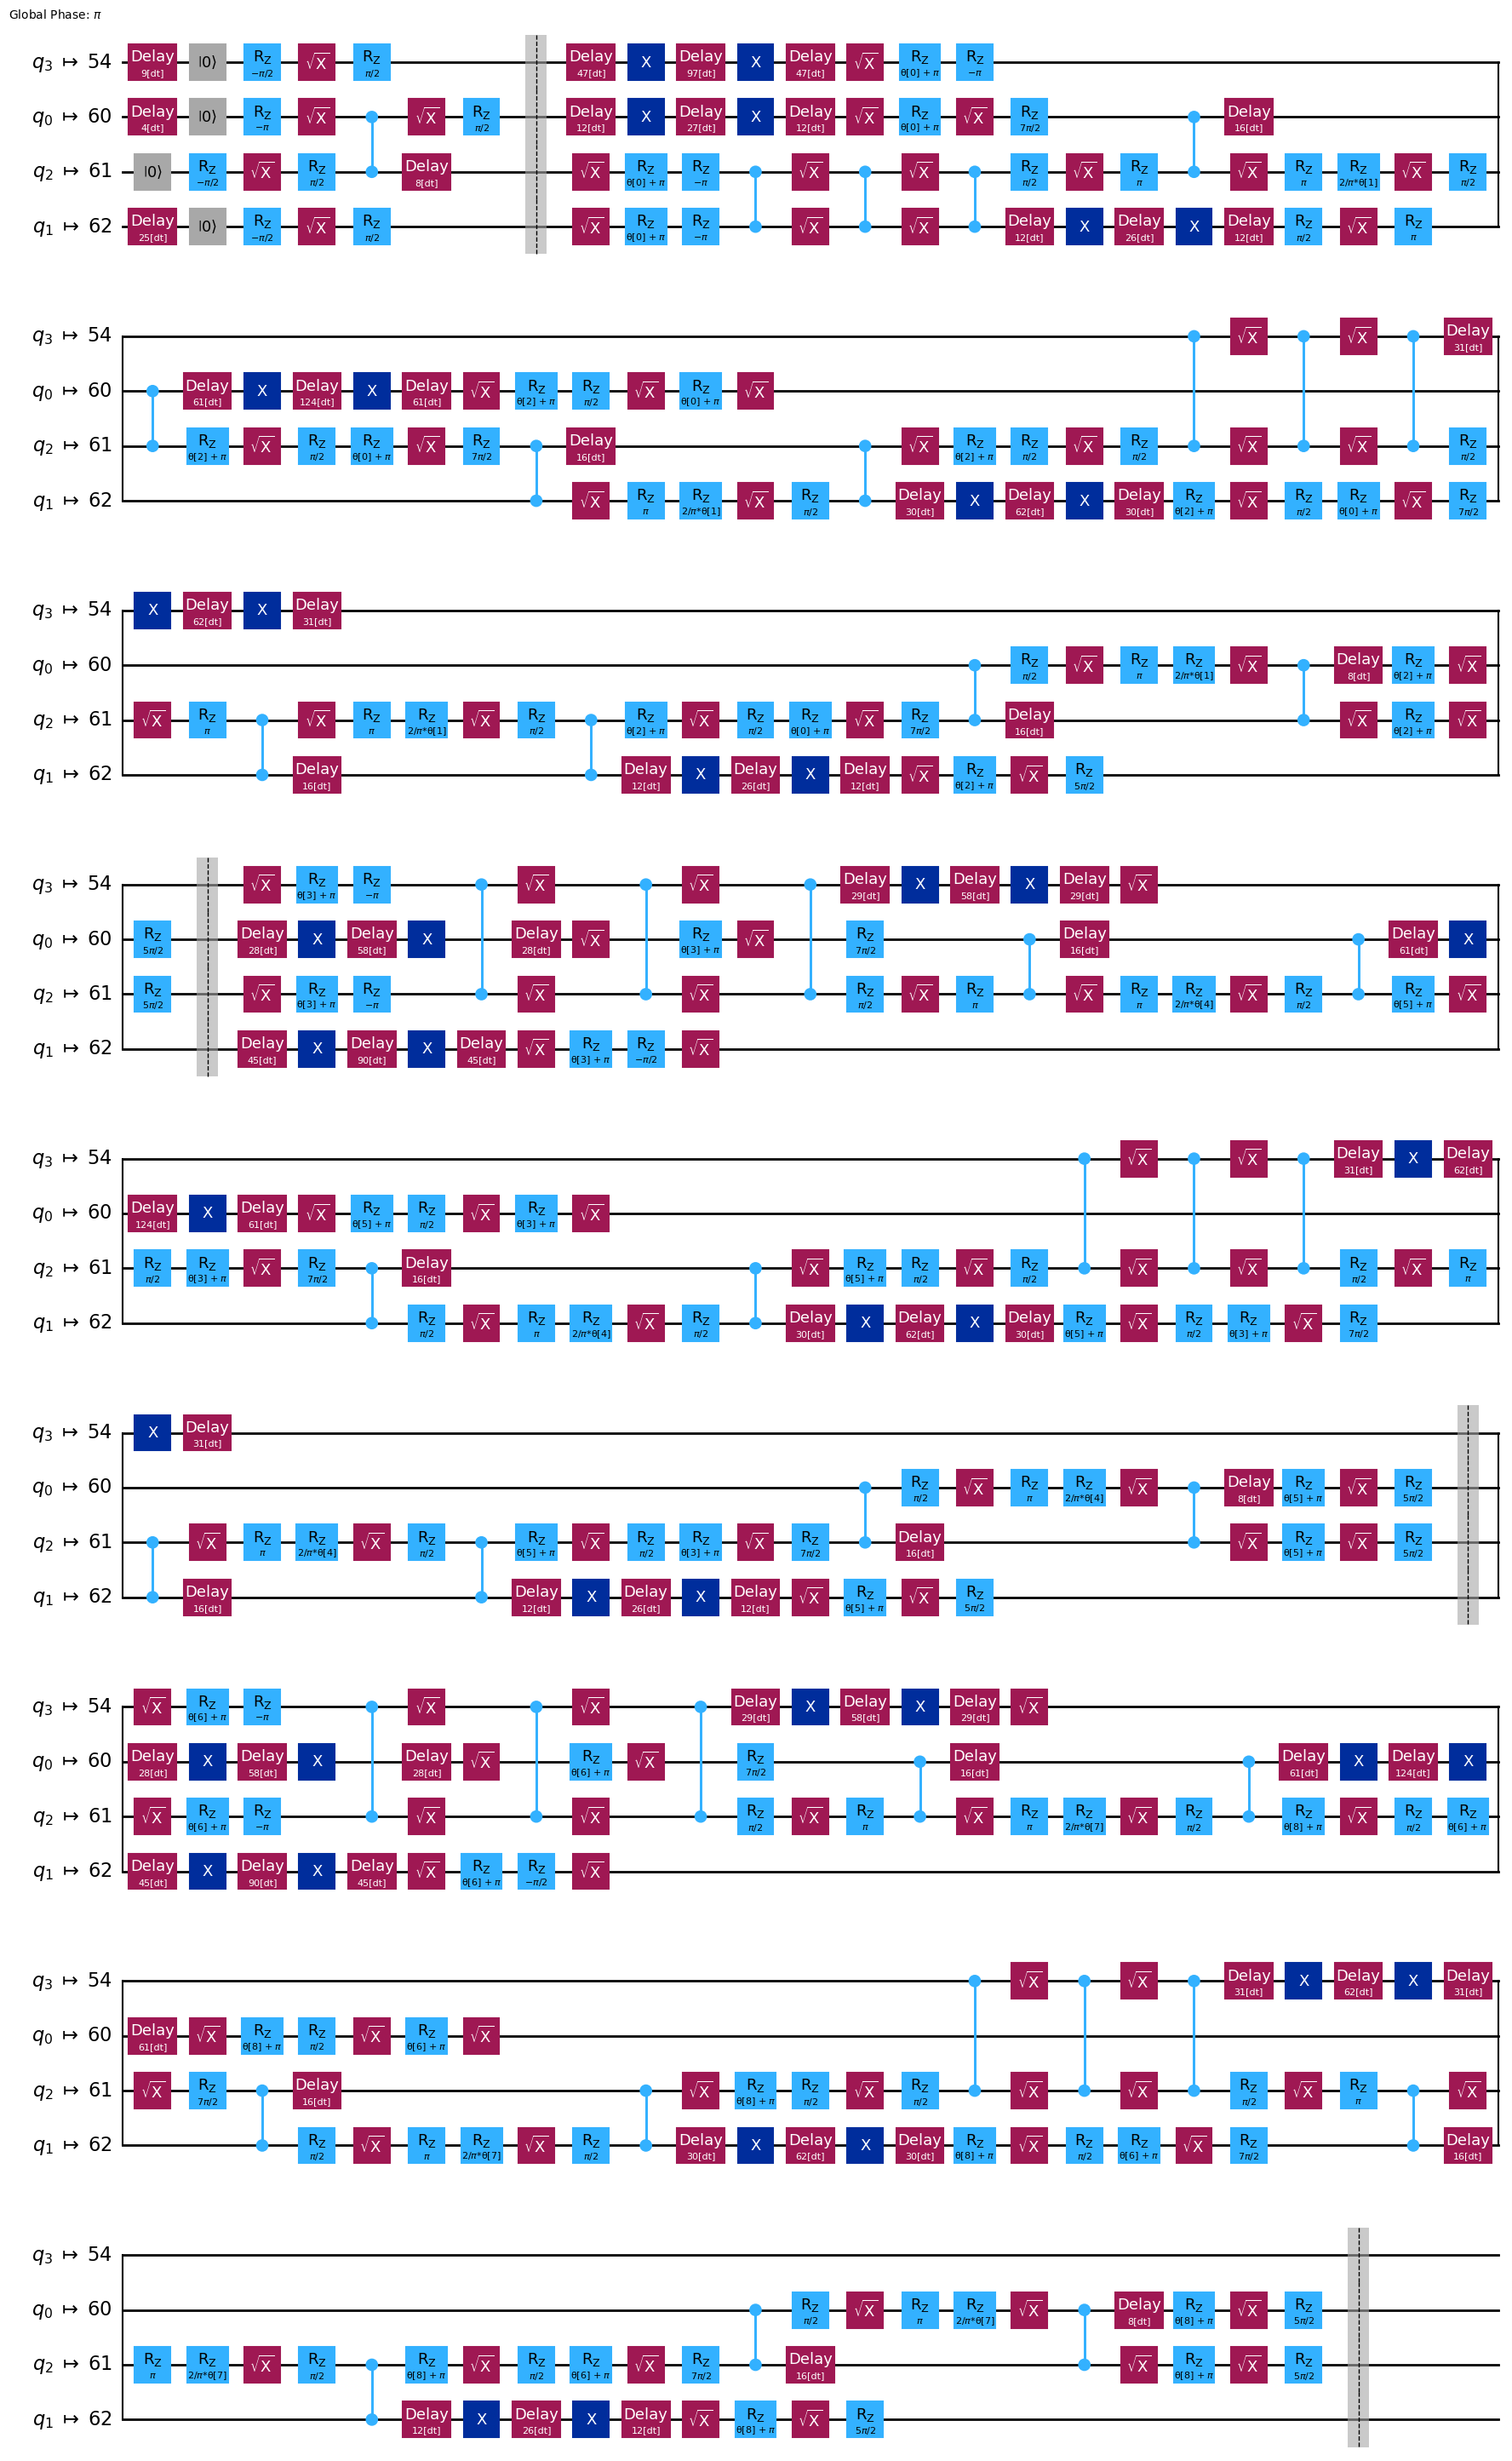

In [25]:
# Transpile/schedule/DD
circuit_ibm = pm.run(circuit)

# Map observable to physical qubit layout
hamiltonian_ibm = Hm_norm.apply_layout(circuit_ibm.layout)

print("Depth after transpilation:", circuit_ibm.decompose(reps=5).depth())
print(
    f"2+ qubit depth: {circuit_ibm.decompose(reps=5).depth(lambda instr: len(instr.qubits) > 1)}"
)

circuit_ibm.draw(output='mpl')

## Qiskit Patterns Step 3: Execute using Qiskit Primitives

Once the *QGHNN* circuit is constructed, we need to evaluate the *loss* and compute gradients to update the variational parameters $\theta$.

The *forward pass* prepares the quantum state $|\psi(\theta)\rangle$ using the *QGHNN* circuit and computes:

- The expectation value of the topological Hamiltonian for the current quantum state: $\langle \mathcal{H}_m \rangle_{\psi_t(\theta)} = Loss(\theta) = \langle \psi_t(\theta) | \mathcal{H}_m | \psi_t(\theta) \rangle.$
- The *Gap*, which is the difference between the estimated expectation value and the ground state energy of the mapping Hamiltonian, $Gap = \left| \text{Loss}(\theta) - \lambda_0\right|$.

In [31]:
from qiskit.primitives import StatevectorEstimator as Estimator

def forward_pass(
    circuit: QuantumCircuit,
    weight_params: np.ndarray,      # shape (len(theta_params),)
    estimator: Estimator,           # EstimatorV2 or StatevectorEstimator
    observable: SparsePauliOp,      # mapping Hamiltonian: Hm_norm
    log=False,
) -> tuple[float, float]:
    """
    Forward pass of the QGHNN

    Args:
        circuit: circuit consisting amplitude-encoded adjacency and the neural network ansatz.
        input_params: batch of amplitude-encoded adjacency vectors (normalized).
        weight_params: ansatz parameters θ.
        estimator: Estimator primitive (hardware or simulator).
        observable: mapping Hamiltonian (SparsePauliOp).

    Returns:
        loss: expectation value ⟨ψ(θ)|Hm|ψ(θ)⟩
        gap:  |loss - λ0|
    """

    params_row = np.atleast_2d(np.asarray(weight_params)).tolist()

    pub = (circuit, [observable], params_row)
    job = estimator.run([pub])
    result = job.result()[0]
    
    loss = float(result.data.evs[0])
    gap = abs(loss - min_ev_norm)

    global cost_history_dict
    
    if log:
        cost_history_dict["iters"] += 1
        cost_history_dict["prev_vector"] = weight_params
        cost_history_dict["loss_history"].append(loss)
        cost_history_dict["gap_history"].append(gap)

    return loss, gap

### Optimizer 1 — Finite Difference Gradient Descent

In the training period, we optimize the parameter vector $\theta$, using *finite-difference gradient estimation*. For each parameter $\theta_j$, the gradient of the loss function is approximated using a *symmetric finite difference*:

$$
\frac{\partial Loss(\theta)}{\partial \theta_j} =
\frac{Loss(\theta_j + \Delta_j) -Loss(\theta_j - \Delta_j)}{2 \Delta_j}
$$

where $\Delta_j = \epsilon$ is a small shift applied to a single parameter.    

Once we compute the gradient, we update the parameters using the standard *gradient descent update rule*:

$$
\theta_j^{(t+1)} = \theta_j^{(t)} - R \cdot 
\frac{\partial Loss(\theta)}{\partial \theta_j}
$$

where $R$ is the learning rate and $t$ is the iteration number.

In [34]:
# Build the parameterized circuit and parameter vector
L = 3  # number of layers
circuit, theta_params = build_qghnn_circuit(A_norm, qubits, edges_list, L)

# Estimator primitive (simulator for debbuging)
estimator = Estimator()


# Define a helper function
def compute_loss(theta_vals):
    """
    Compute the expectation value (loss) for given parameters.

    Args:
        theta_vals (np.ndarray): Current parameter vector.
    
    Returns:
        float: Expectation value ⟨ψ(θ)|Hm|ψ(θ)⟩
    """
    loss, _ = forward_pass(
        circuit,          
        theta_vals,       
        estimator,        
        Hm_norm,          
        log=False        
    )
    return loss


import time
# ============= OPTIMIZER 1: Finite Difference =============
print(f"\n{'='*80}")
print("OPTIMIZER 1: Finite Difference Gradient Descent")
print(f"{'='*80}")

# hyper parameters
np.random.seed(42)
theta_vals = np.random.randn(len(theta_params)) * 0.05
learning_rate = 0.1
epsilon = 1e-3
max_iters = 500

# Global history dictionary (same as your original style)
cost_history_dict = {
    "prev_vector": None,
    "iters": 0,
    "loss_history": [],
    "gap_history": []
}

print("Training with Finite Difference Gradient Descent..")
start_time = time.time()
for it in range(max_iters):
    grads = np.zeros_like(theta_vals)
    for j in range(len(theta_vals)):
        w_plus = theta_vals.copy(); w_plus[j] += epsilon
        w_minus = theta_vals.copy(); w_minus[j] -= epsilon
        loss_plus = compute_loss(w_plus)
        loss_minus = compute_loss(w_minus)
        grads[j] = (loss_plus - loss_minus) / (2.0 * epsilon)
    
    # Update parameters
    theta_vals -= learning_rate * grads
    
    # Log once per iteration
    loss = compute_loss(theta_vals)
    gap = abs(loss - min_ev_norm)
    cost_history_dict["loss_history"].append(loss)
    cost_history_dict["gap_history"].append(gap)
    cost_history_dict["iters"] += 1
    cost_history_dict["prev_vector"] = theta_vals
    
    if it % 40 == 0 or it == max_iters - 1:
        print(f"  Iter {it+1:3d}: Loss={loss:.6f}, Gap={gap:.6f}, |∇|={np.linalg.norm(grads):.6f}")

fd_time = time.time() - start_time


OPTIMIZER 1: Finite Difference Gradient Descent
Training with Finite Difference Gradient Descent..
  Iter   1: Loss=-0.000250, Gap=0.999750, |∇|=0.067014
  Iter  41: Loss=-0.295522, Gap=0.704478, |∇|=0.324601
  Iter  81: Loss=-0.507064, Gap=0.492936, |∇|=0.133462
  Iter 121: Loss=-0.529431, Gap=0.470569, |∇|=0.044628
  Iter 161: Loss=-0.535865, Gap=0.464135, |∇|=0.037152
  Iter 201: Loss=-0.540437, Gap=0.459563, |∇|=0.030111
  Iter 241: Loss=-0.543065, Gap=0.456935, |∇|=0.021161
  Iter 281: Loss=-0.544226, Gap=0.455774, |∇|=0.013265
  Iter 321: Loss=-0.544654, Gap=0.455346, |∇|=0.007777
  Iter 361: Loss=-0.544796, Gap=0.455204, |∇|=0.004408
  Iter 401: Loss=-0.544841, Gap=0.455159, |∇|=0.002465
  Iter 441: Loss=-0.544855, Gap=0.455145, |∇|=0.001382
  Iter 481: Loss=-0.544859, Gap=0.455141, |∇|=0.000794
  Iter 500: Loss=-0.544860, Gap=0.455140, |∇|=0.000621


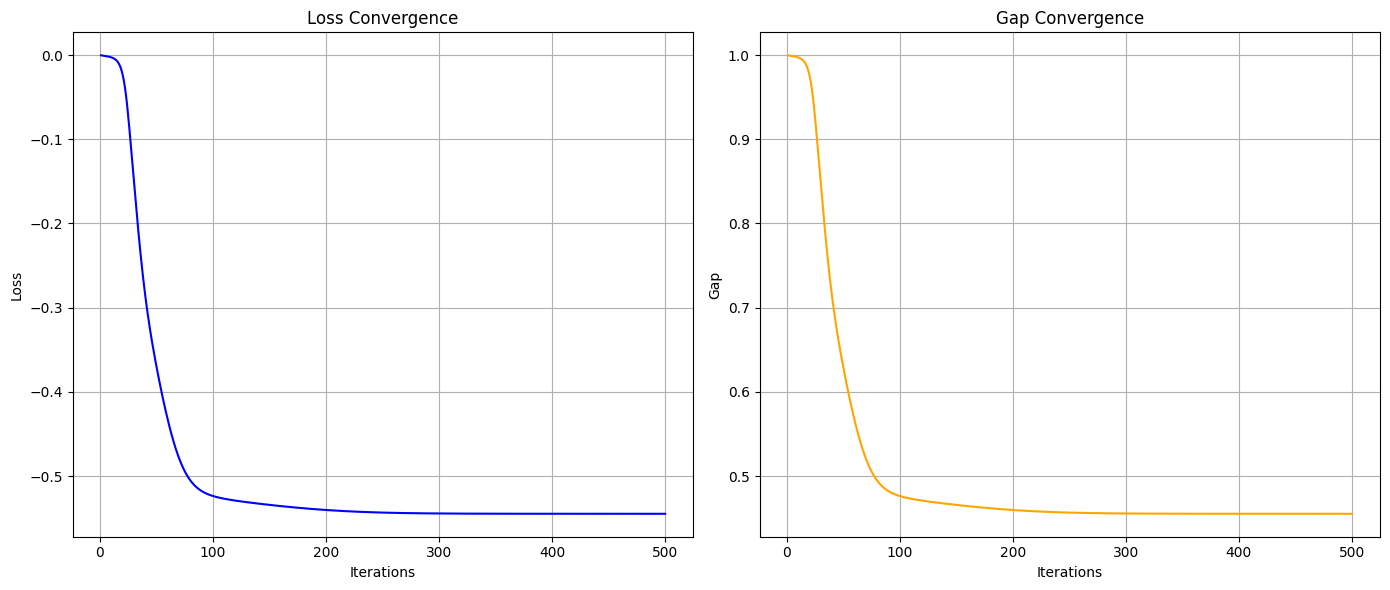

In [36]:
import matplotlib.pyplot as plt

iters = np.arange(1, len(cost_history_dict["loss_history"]) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(iters, cost_history_dict["loss_history"], color="blue")
ax1.set_xlabel("Iterations"); ax1.set_ylabel("Loss")
ax1.set_title("Loss Convergence"); ax1.grid(True)

ax2.plot(iters, cost_history_dict["gap_history"], color="orange")
ax2.set_xlabel("Iterations"); ax2.set_ylabel("Gap")
ax2.set_title("Gap Convergence"); ax2.grid(True)

plt.tight_layout()

This whole loop implements a *QGHNN* training procedure:

1. Encode input data (*Adjecency Matrix*) as the initial quantum state using amplitude encoding.
2. Evolve $|\psi_{in}\rangle$ with a trainable ansatz circuit $U(\theta)$.
3. Measure an observable $O$ → gives *Loss* as the expectation value $\langle O \rangle$.
4. Compute *Gap* as the difference between $\langle O \rangle$ and the *mapping Hamiltonian*.
5. Optimize $\theta$ to minimize the *Loss* and the *Gap* using the *gradient descent*.
6. Repeat until convergence.

The quantum state $|\psi_t(\theta)\rangle$ evolves under the circuit Hamiltonian $H_c$ defined by the variational quantum circuit $U(\theta)$. The goal of training is to optimize the parameters $\theta$ such that the evolved quantum state best matches the properties of $H_m$. 

Formally, the loss function is:

$$
Loss(\theta) = \langle \psi_t(\theta) | \mathcal{H}_m | \psi_t(\theta) \rangle
$$

where $|\psi_t(\theta)\rangle = U(\theta)|\psi_{\text{in}}\rangle$ and $|\psi_{\text{in}}\rangle$ is the amplitude-encoded input state, and we are minimizing $Loss(\theta)$ over the parameter vector $\theta$.

## Qiskit Patterns Step 4: Post-Process, Classical Results

### Reconstructing the Adjacency Matrix

Given the final quantum state $|\psi_{out}\rangle = \sum_{k=0}^{2^n-1} c_k |k\rangle,$ the amplitudes $c_k \in \mathbb{C}$ may directly encode the entries of the learned adjacency matrix. Since, the initial strategy was *amplitude encoding*, the first $n^2$ amplitudes correspond to the entries of the adjacency matrix. We keep only the real part because the true adjacency is real and non‑negative, while the variational circuit may introduce small imaginary components. Thus, the adjacency elements are recovered from the real part of the amplitudes:

$$
A_{ij}^{\text{est}} = \operatorname{Re}(c_k)
$$

Because adjacency values are non-negative, we impose: $A_{ij}^{\text{est}} \ge 0,$ clipping numerical noise below zero.

In addition, quantum amplitudes are normalized $\sum_k |c_k|^2 = 1$, so the reconstructed matrix generally has a different scale than the true adjacency $A_{\text{true}}$. To restore the correct physical weight of edges, we rescale using the *Frobenius norm*:

$$
A_{\text{est}} \leftarrow A_{\text{est}} \cdot 
\frac{\|A_{\text{true}}\|_F}{\|A_{\text{est}}\|_F},
\qquad
\|A\|_F = \sqrt{\sum_{i,j} A_{ij}^2} = \sqrt{\operatorname{Tr}(A^{T}A)}
$$

Thus, the output is a reconstructed adjacency matrix inferred from the quantum state amplitudes.

In [40]:
def reconstruct_adjacency_from_state_amplitude(psi, n, A_true):
    """
    Amplitude-based adjacency reconstruction.

    Args:
        psi: 1-D complex statevector (array-like).
        n: number of graph nodes (adjacency is n x n).
        A_true: ground-truth adjacency (used only for Frobenius rescaling).

    Returns:
        A_est: reconstructed n x n real adjacency matrix (rescaled).
    """
    amps = np.asarray(psi).ravel()
    A_est = np.real(amps[: n * n]).reshape((n, n))
    # If adjacency is nonnegative, clip tiny negatives from numerical noise
    A_est = np.clip(A_est, 0.0, None)
    # Rescale to match Frobenius norm of A_true
    norm_true = np.linalg.norm(A_true, 'fro')
    norm_est = np.linalg.norm(A_est, 'fro')
    if norm_est > 0 and norm_true > 0:
        A_est *= norm_true / norm_est
    return A_est

### Evaluation Metrics

To rigorously assess how accurately the reconstructed adjacency matrix $A_{\text{est}}$ approximates the true graph structure $A_{\text{true}}$, we compute four complementary metrics.  
For evaluation, both $n \times n$ adjacency matrices are compared element-wise, after being flattened into vectors of length $N = n^2$:

$$
A_{\text{true}} \rightarrow (A_{1}^{\text{true}}, A_{2}^{\text{true}}, \dots, A_{N}^{\text{true}}),
\qquad
A_{\text{est}} \rightarrow (A_{1}^{\text{est}}, A_{2}^{\text{est}}, \dots, A_{N}^{\text{est}})
$$

where $n$ is the number of nodes.

#### 1. Mean Squared Error (MSE)

The *Mean Squared Error* measures the average squared deviation between corresponding adjacency entries:

$$
\text{MSE}(A_{\text{true}}, A_{\text{est}}) =
\frac{1}{N} \sum_{k=1}^{N}
\left(A_{k}^{\text{true}} - A_{k}^{\text{est}}\right)^2,
\qquad
N = n^2
$$

A value close to zero implies that the estimated adjacency closely approximates the true one:

$$
\text{MSE} \to 0 \quad \Rightarrow \quad A_{\text{est}} \approx A_{\text{true}}
$$


#### 2. Cosine Similarity

Cosine similarity quantifies the *directional alignment* between the flattened matrices, independent of magnitude:

$$
\text{CosSim}(A_{\text{true}}, A_{\text{est}}) =
\frac{
\langle A_{\text{true}}, A_{\text{est}} \rangle
}{
\|A_{\text{true}}\|_2 \, \|A_{\text{est}}\|_2
},
\qquad
\langle X, Y \rangle = \sum_{i,j} X_{ij} Y_{ij}
$$

Interpretation:

- $\text{CosSim} = 1$: perfect structural alignment  
- $\text{CosSim} = 0$: no shared structure  
- $\text{CosSim} < 0$: inverted structure

Thus, cosine similarity evaluates whether the learned connectivity pattern matches the true graph directionally.

#### 3. Frobenius Norm

The *Frobenius norm* measures the total reconstruction error over all entries:

$$
\|A_{\text{true}} - A_{\text{est}}\|_{F} =
\sqrt{\sum_{i,j}\left(A_{ij}^{\text{true}} - A_{ij}^{\text{est}}\right)^2}
$$

Since the Frobenius norm satisfies:

$$
\|A\|_{F} = \sqrt{\operatorname{Tr}\!\left(A^T A\right)},
$$

a smaller value of $\|A_{\text{true}} - A_{\text{est}}\|_{F}$ indicates that both the global structure and total edge weights are well preserved.


#### 4. Pearson Correlation Coefficient

The *Pearson correlation coefficient* captures how adjacency values co-vary:

$$
r(A_{\text{true}}, A_{\text{est}}) =
\frac{
\sum_{k=1}^{N}
\left(A_{k}^{\text{true}} - \bar{A}_{\text{true}}\right)
\left(A_{k}^{\text{est}} - \bar{A}_{\text{est}}\right)
}{
\sqrt{\sum_{k=1}^{N}\left(A_{k}^{\text{true}} - \bar{A}_{\text{true}}\right)^2}
\,
\sqrt{\sum_{k=1}^{N}\left(A_{k}^{\text{est}} - \bar{A}_{\text{est}}\right)^2}
}
$$

where $A_{k}^{\text{true}}, A_{k}^{\text{est}}$ are corresponding matrix entries and $\bar{A}_{\text{true}}, \bar{A}_{\text{est}}$ are their mean values.

Interpretation:
- $r = +1$: perfect linear correspondence — both matrices vary together  
- $r = 0$: no linear dependency  
- $r = -1$: perfect inverse dependence  

Thus, high correlation indicates that changes in edge strength are learned consistently, even if exact values differ.

In [43]:
def metrics(A_true: np.ndarray, A_est: np.ndarray):
    """
    Compute reconstruction quality metrics between the target adjacency matrix and the estimated one.

    Args:
        A_true: ground-truth adjacency matrix, shape (n, n).
        A_est: estimated adjacency matrix, shape (n, n).

    Returns:
        mse: Mean squared error between flattened matrices.
        cos_sim: Cosine similarity between flattened matrices (in [-1, 1]).
        frob: Frobenius norm of the difference (||A_true - A_est||_F).
        corr: Pearson correlation coefficient between flattened matrices.
    """
    # Flatten matrices to compare element-wise as vectors
    v_true = A_true.flatten()
    v_est = A_est.flatten()

    # Mean squared error: average squared element-wise difference
    mse = np.mean((v_true - v_est) ** 2)

    # Cosine similarity: dot(v_true, v_est) / (||v_true|| * ||v_est||)
    denom = np.linalg.norm(v_true) * np.linalg.norm(v_est)
    cos_sim = (np.dot(v_true, v_est) / denom) if denom != 0 else 0.0

    # Frobenius norm of the difference: sqrt(sum_ij (A_true - A_est)^2)
    frob = np.linalg.norm(A_true - A_est, 'fro')

    # Pearson correlation between flattened vectors
    # Only defined when both vectors have nonzero standard deviation
    if np.std(v_true) > 0 and np.std(v_est) > 0:
        corr = np.corrcoef(v_true, v_est)[0, 1]
    else:
        corr = 0.0

    return mse, cos_sim, frob, corr

After training the *Quantum Graph Hamiltonian Neural Network*, the final quantum state:

$$
|\psi_{\text{out}}\rangle = U(\theta)\,|\psi_{\text{in}}\rangle
$$

contains the learned graph structure in its *amplitudes*. The trained parameters $\theta$ are substituted into the circuit to produce the final statevector:

$$
|\psi_{\text{out}}\rangle = \text{Statevector}\big(U(\theta_{\text{trained}})\big).
$$

All in all, the four metrics we introduced before, evaluate reconstruction accuracy and offer a complete quantitative perspective:
- *MSE* captures element-wise precision.
- *Cosine similarity* measures global structural alignment.
- *Frobenius norm* quantifies total reconstruction error.
- *Correlation* checks whether edge variations are faithfully learned.

This combination provides a robust evaluation of quantum graph reconstruction fidelity. Thus, this code decodes the graph embedded in the quantum amplitude space and evaluates how accurately the *QHGNN* learns the graph’s adjacency structure.

In [46]:
from qiskit.quantum_info import Statevector

# Assign trained parameters
trained_circuit = circuit.assign_parameters(dict(zip(theta_params, theta_vals)))

# Get the final statevector
psi = Statevector.from_instruction(trained_circuit)

# Define the true adjacency from the target graph
A_true = rx.adjacency_matrix(G)
A_true = np.array(A_true, dtype=float)

psi = Statevector.from_instruction(trained_circuit).data 
A_est = reconstruct_adjacency_from_state_amplitude(psi, n, A_true)

# Compute metrics
mse, cos_sim, frob, corr = metrics(A_true, A_est)
print("\n=== FINITE DIFFERENCE RESULTS ===")
print(f"Time: {fd_time:.2f}s")
print("MSE:", mse)
print("Cosine similarity:", cos_sim)
print("Frobenius norm:", frob)
print("Correlation coefficient:", corr)


=== FINITE DIFFERENCE RESULTS ===
Time: 134.57s
MSE: 0.32423588532013486
Cosine similarity: 0.6757641146798651
Frobenius norm: 2.2776685810543547
Correlation coefficient: 0.4631446339533246


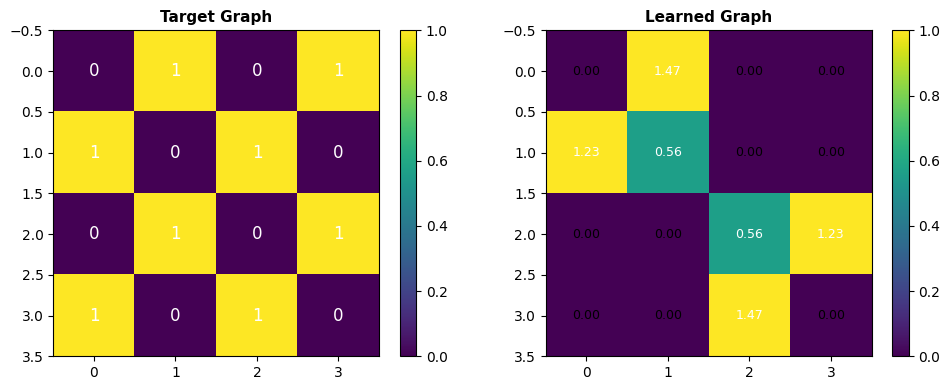

In [50]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], figure=fig)

# Target adjacency
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(A_true, cmap='viridis', vmin=0, vmax=1)
ax1.set_title("Target Graph", fontsize=11, fontweight='bold')
for i in range(n):
    for j in range(n):
        ax1.text(j, i, f'{A_true[i,j]:.0f}', ha='center', va='center',
                 color='white', fontsize=12)
plt.colorbar(im1, ax=ax1, fraction=0.046)

# Learned adjacency (Finite Difference)
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(A_est, cmap='viridis', vmin=0, vmax=1)
ax2.set_title("Learned Graph", fontsize=11, fontweight='bold')
for i in range(n):
    for j in range(n):
        color = 'white' if A_est[i,j] > 0.5 else 'black'
        ax2.text(j, i, f"{A_est[i,j]:.2f}", ha='center', va='center', color=color, fontsize=9)
plt.colorbar(im2, ax=ax2, fraction=0.046)

plt.tight_layout()

## Qiskit Patterns Step 3 & 4 Revisited: Improving the Training Strategy

The model did not converge to the correct ground-state energy, nor did the reconstructed adjacency accurately match the target graph. This indicates that, with the current optimizer, the QGNN is likely trapped in a local minimum: it partially lowers the Hamiltonian energy but fails to learn the correct graph structure. To address this limitation, we revisit the training phase and explore alternative gradient-based strategies, including classical quasi-Newton solvers and stochastic gradient estimators.

### Optimizer 2 — SLSQP (Sequential Least Squares Programming)

The *Sequential Least Squares Programming* (SLSQP) algorithm is a deterministic, gradient‑based optimizer belonging to the broader class of Sequential Quadratic Programming (SQP) methods. In the absence of analytic gradients, SLSQP computes $\nabla \mathrm{Loss}(\theta)$ numerically using finite differences, making it well suited for smooth variational objectives such as Hamiltonian expectation values obtained from statevector simulation.

Let $\mathrm{Loss}(\theta)$ denote the expectation value of the mapping Hamiltonian with respect to the variational state $|\psi(\theta)\rangle$. At
iteration $k$, SLSQP constructs a local quadratic approximation of the nonlinear objective by solving the subproblem

$$
\min_{p}\;
\nabla \mathrm{Loss}(\theta_k)^{T} p
+
\frac{1}{2} p^{T} B_k p,
$$

where $p \in \mathbb{R}^n$ is a search direction,  $\nabla \mathrm{Loss}(\theta_k)$ is the gradient evaluated at $\theta_k$, and $B_k$ is a quasi‑Newton approximation of the local curvature, encoding second‑order information about how the loss varies with respect to the circuit parameters.

The parameters are then updated via a line‑search step,

$$
\theta_{k+1} = \theta_k + \alpha_k p_k,
$$

where the step size $\alpha_k$ is chosen to ensure sufficient decrease in the objective. Through this SQP formulation, SLSQP incorporates curvature information directly by solving a new quadratic subproblem at each iteration.

In our implementation, the variational parameters are initialized randomly and optimized using SLSQP via the `scipy.optimize.minimize` interface. At each iteration, the objective function evaluates the Hamiltonian expectation value and records both the loss and the energy gap. After convergence, the optimized parameters are inserted into the QGHNN circuit to obtain the final statevector, from which the reconstructed adjacency matrix and evaluation metrics are computed.

In [54]:
from scipy.optimize import minimize

# Build the parameterized circuit and parameter vector
L = 3  # number of layers
circuit, theta_params = build_qghnn_circuit(A_norm, qubits, edges_list, L)

# Estimator primitive (simulator)
estimator = Estimator()

# ============= OPTIMIZER 2: SLSQP =============
print(f"\n{'='*80}")
print("OPTIMIZER 2: SLSQP (Sequential Least Squares Programming)")
print(f"{'='*80}")

# Initialize parameters
np.random.seed(42)
theta_init_slsqp = np.random.randn(len(theta_params)) * 0.01

# History dictionary (same format as finite-difference)
slsqp_history = {
    "loss": [],
    "gap": []
}

# Objective function for SLSQP
def objective_slsqp(theta):
    loss = compute_loss(theta)
    gap = abs(loss - min_ev_norm)
    slsqp_history["loss"].append(loss)
    slsqp_history["gap"].append(gap)
    if len(slsqp_history["loss"]) % 40 == 0:
        print(f"  Iter {len(slsqp_history['loss']):3d}: Loss={loss:.6f}, Gap={gap:.6f}")
    return loss

print("Training with SLSQP...")
start_time = time.time()
res_slsqp = minimize(objective_slsqp,
                     theta_init_slsqp,
                     method='SLSQP',
                     options={'maxiter': 500, 'ftol': 1e-8, 'disp': False})
slsqp_time = time.time() - start_time

# Define the true adjacency from the target graph
A_true = rx.adjacency_matrix(G)
A_true = np.array(A_true, dtype=float)

# Reconstruction after training
trained_circuit_slsqp = circuit.assign_parameters(dict(zip(theta_params, res_slsqp.x)))
psi_slsqp = Statevector.from_instruction(trained_circuit_slsqp).data
A_est_slsqp = reconstruct_adjacency_from_state_amplitude(psi_slsqp, n, A_true)

# Compute metrics
mse, cos_sim, frob, corr = metrics(A_true, A_est_slsqp)
print("\n=== SLSQP RESULTS ===")
print(f"Time: {slsqp_time:.2f}s")
print("MSE:", mse)
print("Cosine similarity:", cos_sim)
print("Frobenius norm difference:", frob)
print("Correlation coefficient:", corr)


OPTIMIZER 2: SLSQP (Sequential Least Squares Programming)
Training with SLSQP...
  Iter  40: Loss=-0.061849, Gap=0.938151
  Iter  80: Loss=-0.487642, Gap=0.512358
  Iter 120: Loss=-0.534590, Gap=0.465410
  Iter 160: Loss=-0.643347, Gap=0.356653
  Iter 200: Loss=-0.749625, Gap=0.250375
  Iter 240: Loss=-0.806635, Gap=0.193365
  Iter 280: Loss=-0.807527, Gap=0.192473
  Iter 320: Loss=-0.807569, Gap=0.192431

=== SLSQP RESULTS ===
Time: 8.82s
MSE: 0.0034432254734362506
Cosine similarity: 0.9965567745265638
Frobenius norm difference: 0.23471601473904588
Correlation coefficient: 0.9931488732689518


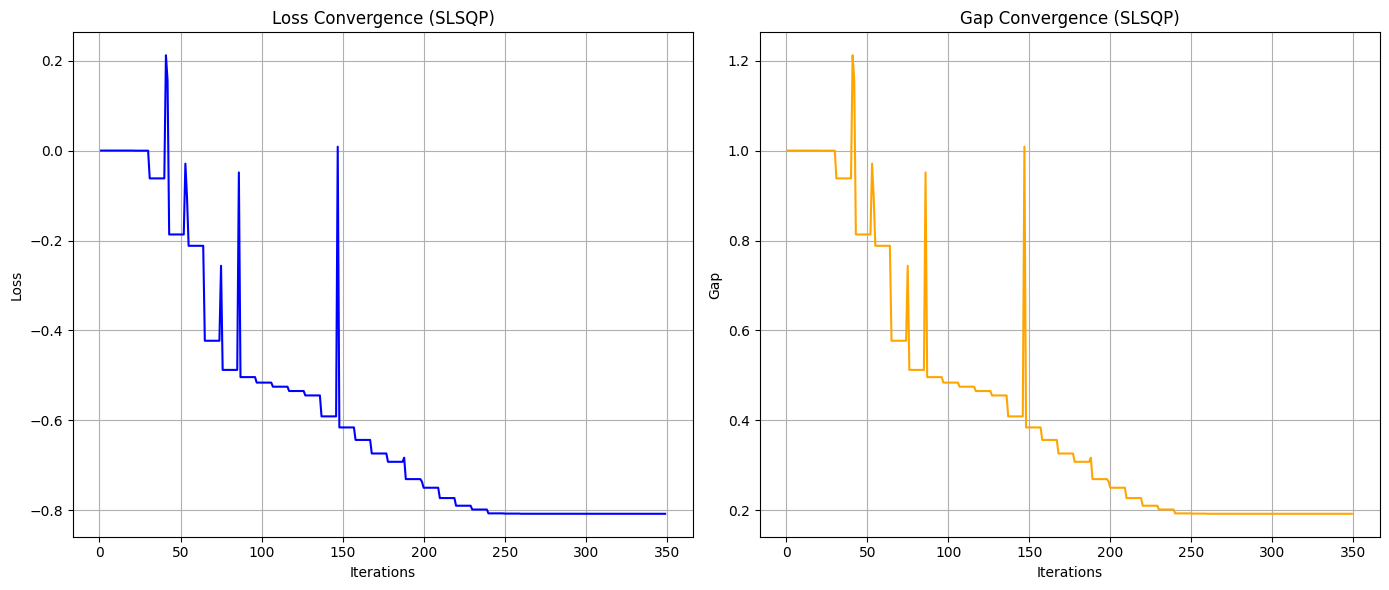

In [56]:
import matplotlib.pyplot as plt

iters = np.arange(1, len(slsqp_history["loss"]) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(iters, slsqp_history["loss"], color="blue")
ax1.set_xlabel("Iterations"); ax1.set_ylabel("Loss")
ax1.set_title("Loss Convergence (SLSQP)"); ax1.grid(True)

ax2.plot(iters, slsqp_history["gap"], color="orange")
ax2.set_xlabel("Iterations"); ax2.set_ylabel("Gap")
ax2.set_title("Gap Convergence (SLSQP)"); ax2.grid(True)

plt.tight_layout()

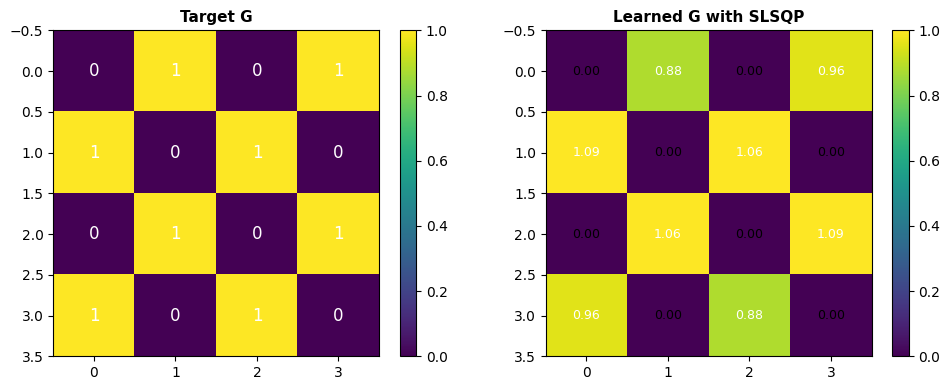

In [58]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], figure=fig)

# Target adjacency
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(A_true, cmap='viridis', vmin=0, vmax=1)
ax1.set_title("Target G", fontsize=11, fontweight='bold')
for i in range(n):
    for j in range(n):
        ax1.text(j, i, f'{A_true[i,j]:.0f}', ha='center', va='center',
                 color='white', fontsize=12)
plt.colorbar(im1, ax=ax1, fraction=0.046)

# Learned adjacency (SLSQP)
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(A_est_slsqp, cmap='viridis', vmin=0, vmax=1)
ax2.set_title("Learned G with SLSQP", fontsize=11, fontweight='bold')
for i in range(n):
    for j in range(n):
        color = 'white' if A_est_slsqp[i,j] > 0.5 else 'black'
        ax2.text(j, i, f"{A_est_slsqp[i,j]:.2f}", ha='center', va='center',
                 color=color, fontsize=9)
plt.colorbar(im2, ax=ax2, fraction=0.046)

plt.tight_layout()

### Optimizer 3 — SPSA (Simultaneous Perturbation Stochastic Approximation)

Next, we employ the *Simultaneous Perturbation Stochastic Approximation* (SPSA) optimizer, a stochastic gradient‑based method that estimates the gradient using only two circuit evaluations per iteration, independent of the number of parameters.

At iteration $k$, SPSA generates a random perturbation vector $\Delta_k \in \{+1,-1\}^n$, whose entries are independently drawn from a Rademacher distribution. The stochastic gradient estimate is

$$
\widehat{\nabla}_i\,Loss(\theta_k) = \frac{Loss(\theta_k + c_k \Delta_k) -
Loss(\theta_k - c_k \Delta_k)}{2 c_k \, \Delta_{k,i}}.
$$

Here, $c_k > 0$ is a small perturbation parameter. The parameters are then updated
according to

$$
\theta_{k+1} = \theta_k -a_k\,\widehat{\nabla}\,Loss(\theta_k),
$$

where $a_k$ is an iteration‑dependent learning rate.

In our implementation, the circuit parameters are initialized randomly and updated using SPSA for a fixed number of iterations. The stochastic nature of SPSA enables efficient exploration of the parameter space and helps identify parameter configurations that preserve the structural information required for accurate graph reconstruction.

In [61]:
from qiskit.quantum_info import Statevector
from scipy.optimize import minimize
import time

# Build the parameterized circuit and parameter vector
L = 3  # number of layers
circuit, theta_params = build_qghnn_circuit(A_norm, qubits, edges_list, L)

# Estimator primitive (simulator)
estimator = Estimator()

# Define a helper function
def compute_loss(theta_vals):
    """
    Compute the expectation value (loss) for given parameters.

    Args:
        theta_vals (np.ndarray): Current parameter vector.
    
    Returns:
        float: Expectation value ⟨ψ(θ)|Hm|ψ(θ)⟩
    """
    loss, _ = forward_pass(
        circuit,          
        theta_vals,       
        estimator,        
        Hm_norm,          
        log=False        
    )
    return loss

# ============= OPTIMIZER 3: SPSA =============
print(f"\n{'='*80}")
print("OPTIMIZER 3: SPSA (Simultaneous Perturbation Stochastic Approximation)")
print(f"{'='*80}")

class SPSA:
    """SPSA optimizer - uses only 2 function evaluations per iteration (vs 2N for param shift)"""
    def __init__(self, maxiter=300, a=0.05, c=0.1, alpha=0.602, gamma=0.101):
        self.maxiter = maxiter
        self.a = a      # Step size coefficient
        self.c = c      # Perturbation size coefficient
        self.alpha = alpha
        self.gamma = gamma
    
    def optimize(self, objective, x0):
        x = x0.copy()
        history = {"loss": [], "gap": []}
        
        for k in range(1, self.maxiter + 1):
            ak = self.a / (k ** self.alpha)
            ck = self.c / (k ** self.gamma)
            
            # Random perturbation vector with entries ±1
            delta = 2 * np.random.randint(0, 2, size=len(x)) - 1
            
            # Two function evaluations
            loss_plus = objective(x + ck * delta)
            loss_minus = objective(x - ck * delta)
            
            # SPSA gradient approximation
            grad_approx = (loss_plus - loss_minus) / (2 * ck * delta)
            
            # Update parameters
            x = x - ak * grad_approx
            
            # Evaluate current loss
            loss = objective(x)
            gap = abs(loss - min_ev_norm)
            history["loss"].append(loss)
            history["gap"].append(gap)
            
            if k % 40 == 0 or k == self.maxiter:
                print(f"  Iter {k:3d}: Loss={loss:.6f}, Gap={gap:.6f}")
        
        return x, history

# Initialize parameters
np.random.seed(42)
theta_init_spsa = np.random.randn(len(theta_params)) * 0.01
spsa_optimizer = SPSA(maxiter=300, a=0.05, c=0.1)

print("Training with SPSA...")
start_time = time.time()
theta_spsa, spsa_history = spsa_optimizer.optimize(compute_loss, theta_init_spsa)
spsa_time = time.time() - start_time

# Define the true adjacency from the target graph
A_true = rx.adjacency_matrix(G)
A_true = np.array(A_true, dtype=float)

# Reconstruction after training
trained_circuit_spsa = circuit.assign_parameters(dict(zip(theta_params, theta_spsa)))
psi_spsa = Statevector.from_instruction(trained_circuit_spsa).data
A_est_spsa = reconstruct_adjacency_from_state_amplitude(psi_spsa, n, A_true)

# Compute metrics
mse, cos_sim, frob, corr = metrics(A_true, A_est_spsa)
print("\n=== SPSA RESULTS ===")
print(f"Time: {spsa_time:.2f}s")
print("MSE:", mse)
print("Cosine similarity:", cos_sim)
print("Frobenius norm difference:", frob)
print("Correlation coefficient:", corr)


OPTIMIZER 3: SPSA (Simultaneous Perturbation Stochastic Approximation)
Training with SPSA...
  Iter  40: Loss=-0.000042, Gap=0.999958
  Iter  80: Loss=-0.000054, Gap=0.999946
  Iter 120: Loss=-0.000069, Gap=0.999931
  Iter 160: Loss=-0.000086, Gap=0.999914
  Iter 200: Loss=-0.000097, Gap=0.999903
  Iter 240: Loss=-0.000109, Gap=0.999891
  Iter 280: Loss=-0.000124, Gap=0.999876
  Iter 300: Loss=-0.000134, Gap=0.999866

=== SPSA RESULTS ===
Time: 23.89s
MSE: 0.002407996301608348
Cosine similarity: 0.9975920036983916
Frobenius norm difference: 0.19628535560691623
Correlation coefficient: 0.9961169953032136


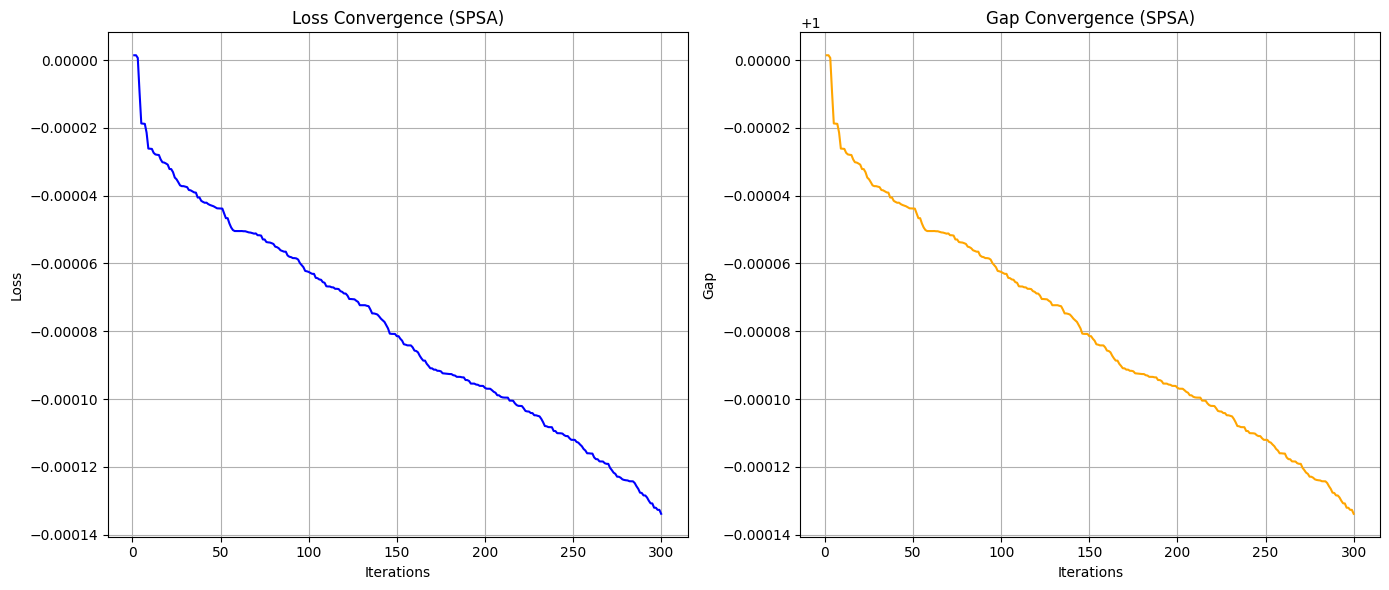

In [63]:
import matplotlib.pyplot as plt

iters = np.arange(1, len(spsa_history["loss"]) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
ax1.plot(iters, spsa_history["loss"], color="blue")
ax1.set_xlabel("Iterations"); ax1.set_ylabel("Loss")
ax1.set_title("Loss Convergence (SPSA)"); ax1.grid(True)

ax2.plot(iters, spsa_history["gap"], color="orange")
ax2.set_xlabel("Iterations"); ax2.set_ylabel("Gap")
ax2.set_title("Gap Convergence (SPSA)"); ax2.grid(True)

plt.tight_layout()

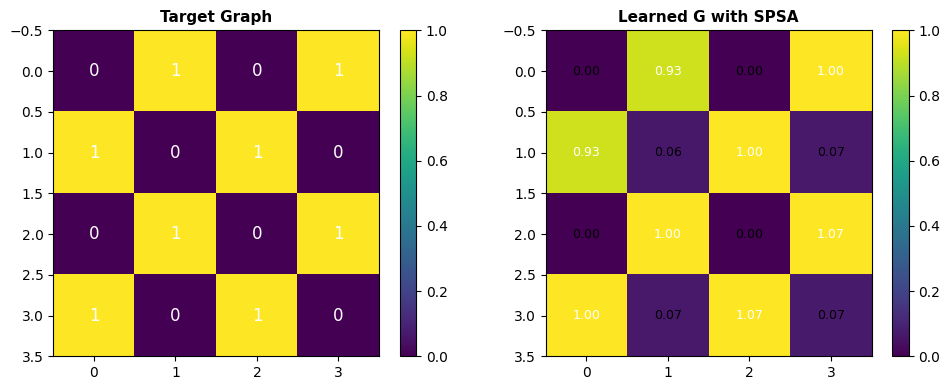

In [65]:
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], figure=fig)

# Target adjacency
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(A_true, cmap='viridis', vmin=0, vmax=1)
ax1.set_title("Target Graph", fontsize=11, fontweight='bold')
for i in range(n):
    for j in range(n):
        ax1.text(j, i, f'{A_true[i,j]:.0f}', ha='center', va='center',
                 color='white', fontsize=12)
plt.colorbar(im1, ax=ax1, fraction=0.046)

# Learned adjacency (SPSA)
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(A_est_spsa, cmap='viridis', vmin=0, vmax=1)
ax2.set_title("Learned G with SPSA", fontsize=11, fontweight='bold')
for i in range(n):
    for j in range(n):
        color = 'white' if A_est_spsa[i,j] > 0.5 else 'black'
        ax2.text(j, i, f"{A_est_spsa[i,j]:.2f}", ha='center', va='center', color=color, fontsize=9)
plt.colorbar(im2, ax=ax2, fraction=0.046)

plt.tight_layout()

### Optimizer 4 — L‑BFGS‑B (Limited‑Memory Broyden–Fletcher–Goldfarb–Shanno)

In the *QGHNN* training framework, the objective is to minimize the expectation value of the mapping Hamiltonian with respect to a parameterized quantum circuit. The resulting optimization landscape is smooth and moderately high‑dimensional, making it well‑suited for quasi‑Newton methods, which exploit curvature information to accelerate convergence. Among these, Limited‑Memory BFGS (L‑BFGS‑B) is particularly effective because it approximates second‑order information using only a limited memory footprint, enabling efficient optimization even when the number of parameters grows.

Let $Loss(\theta)$ denote the Hamiltonian expectation value for parameters $\theta \in \mathbb{R}^n$. Quasi‑Newton methods construct a local quadratic model of the loss around the current iterate:


$$
m_k(p) = Loss(\theta_k) + \nabla Loss(\theta_k)^{T} p + \frac{1}{2} p^{T} B_k p,
$$

where $B_k$ is an approximation of the Hessian matrix.  

*L‑BFGS‑B* updates this approximation using only the most recent parameter and gradient differences, avoiding the need to store or invert the full Hessian. The search direction is obtained by solving:

$$
p_k = - B_k^{-1} \nabla Loss(\theta_k),
$$

followed by a line‑search step that ensures sufficient decrease:

$$
\theta_{k+1} = \theta_k + \alpha_k p_k.
$$

Because the QGHNN loss landscape is smooth and exhibits meaningful curvature, L‑BFGS‑B is able to exploit this structure more effectively than purely first‑order or stochastic methods. In practice, we initialize the parameters randomly and allow L‑BFGS‑B to iteratively refine them using gradient information computed on the simulator.

In [68]:
# ============= OPTIMIZER 4: L-BFGS-B =============
print(f"\n{'='*80}")
print("OPTIMIZER 4: L-BFGS-B (Limited-memory BFGS)")
print(f"{'='*80}")

# Initialize parameters
np.random.seed(42)
theta_init_lbfgs = np.random.randn(len(theta_params)) * 0.01

lbfgs_history = {"loss": [], "gap": []}

def lbfgs_objective(theta):
    loss = compute_loss(theta)
    gap = abs(loss - min_ev_norm)
    lbfgs_history["loss"].append(loss)
    lbfgs_history["gap"].append(gap)

    if len(lbfgs_history["loss"]) % 40 == 0:
        print(f"  Iter {len(lbfgs_history['loss']):3d}: Loss={loss:.6f}, Gap={gap:.6f}")

    return loss

print("Training with L-BFGS-B...")
start_time = time.time()

res_lbfgs = minimize(
    lbfgs_objective,
    theta_init_lbfgs,
    method='L-BFGS-B',
    options={'maxiter': 700}
)

lbfgs_time = time.time() - start_time

# Reconstruction
trained_circuit_lbfgs = circuit.assign_parameters(dict(zip(theta_params, res_lbfgs.x)))
psi_lbfgs = Statevector.from_instruction(trained_circuit_lbfgs).data
A_est_lbfgs = reconstruct_adjacency_from_state_amplitude(psi_lbfgs, n, A_true)

mse, cos_sim, frob, corr = metrics(A_true, A_est_lbfgs)

print("\n=== L-BFGS-B RESULTS ===")
print(f"Time: {lbfgs_time:.2f}s")
print("MSE:", mse)
print("Cosine similarity:", cos_sim)
print("Frobenius norm difference:", frob)
print("Correlation coefficient:", corr)


OPTIMIZER 4: L-BFGS-B (Limited-memory BFGS)
Training with L-BFGS-B...
  Iter  40: Loss=-0.000054, Gap=0.999946
  Iter  80: Loss=-0.052584, Gap=0.947416
  Iter 120: Loss=0.134105, Gap=1.134105
  Iter 160: Loss=-0.079913, Gap=0.920087
  Iter 200: Loss=0.184726, Gap=1.184726
  Iter 240: Loss=-0.618251, Gap=0.381749
  Iter 280: Loss=-0.641904, Gap=0.358096
  Iter 320: Loss=-0.656373, Gap=0.343627
  Iter 360: Loss=-0.669140, Gap=0.330860
  Iter 400: Loss=-0.709454, Gap=0.290546
  Iter 440: Loss=-0.773940, Gap=0.226060
  Iter 480: Loss=-0.840955, Gap=0.159045
  Iter 520: Loss=-0.874280, Gap=0.125720
  Iter 560: Loss=-0.882264, Gap=0.117736
  Iter 600: Loss=-0.884044, Gap=0.115956
  Iter 640: Loss=-0.884269, Gap=0.115731
  Iter 680: Loss=-0.884272, Gap=0.115728

=== L-BFGS-B RESULTS ===
Time: 17.81s
MSE: 0.07185471578472116
Cosine similarity: 0.9281452842152788
Frobenius norm difference: 1.0722291977723506
Correlation coefficient: 0.8571232690257443


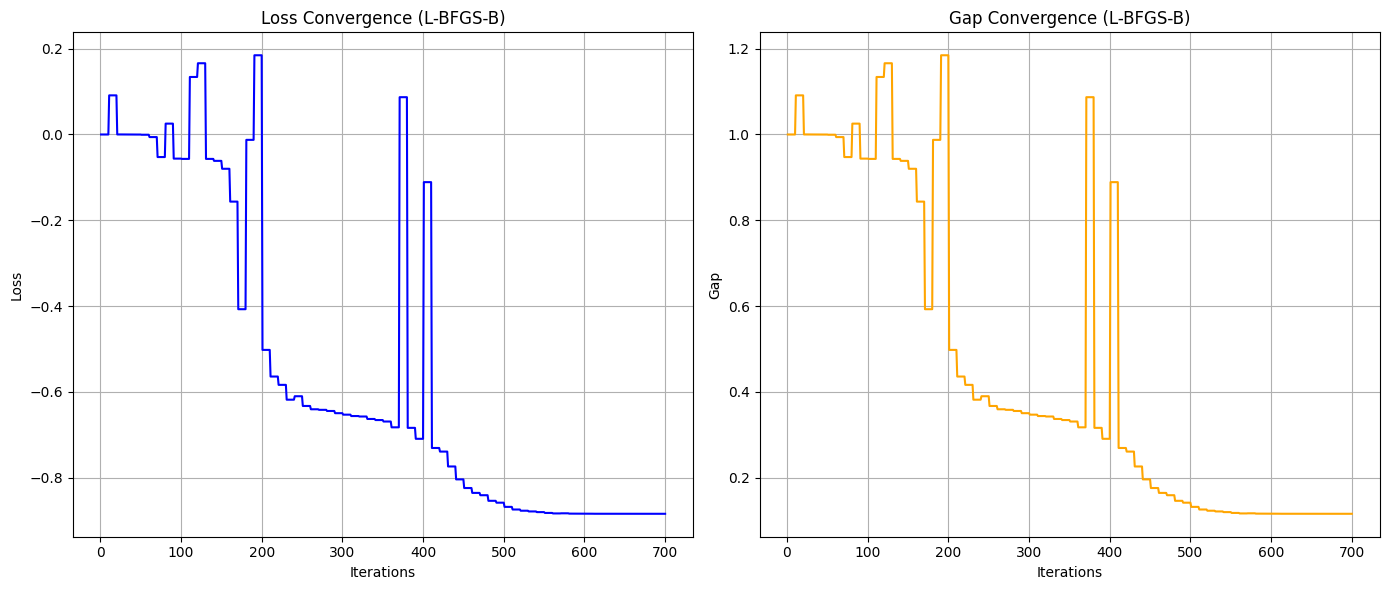

In [80]:
iters = np.arange(1, len(lbfgs_history["loss"]) + 1)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# --- Loss ---
ax1.plot(iters, lbfgs_history["loss"], color="blue")
ax1.set_xlabel("Iterations")
ax1.set_ylabel("Loss")
ax1.set_title("Loss Convergence (L-BFGS-B)")
ax1.grid(True)

# --- Gap ---
ax2.plot(iters, lbfgs_history["gap"], color="orange")
ax2.set_xlabel("Iterations")
ax2.set_ylabel("Gap")
ax2.set_title("Gap Convergence (L-BFGS-B)")
ax2.grid(True)

plt.tight_layout()

plt.savefig("figures/figure8_optimizer4_loss_gap.pdf", format="pdf", bbox_inches="tight")

plt.show()

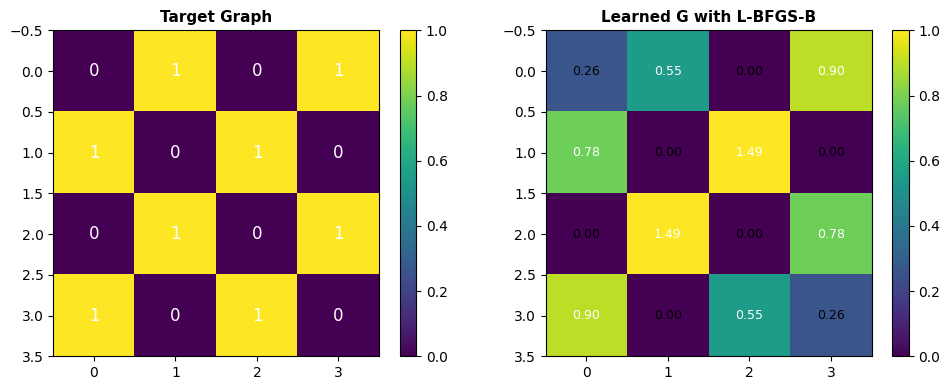

In [82]:
fig = plt.figure(figsize=(10, 4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], figure=fig)

# --- Target adjacency ---
ax1 = fig.add_subplot(gs[0, 0])
im1 = ax1.imshow(A_true, cmap='viridis', vmin=0, vmax=1)
ax1.set_title("Target Graph", fontsize=11, fontweight='bold')

for i in range(n):
    for j in range(n):
        ax1.text(j, i, f'{A_true[i,j]:.0f}',
                 ha='center', va='center',
                 color='white', fontsize=12)

plt.colorbar(im1, ax=ax1, fraction=0.046)

# --- Learned adjacency (L-BFGS-B) ---
ax2 = fig.add_subplot(gs[0, 1])
im2 = ax2.imshow(A_est_lbfgs, cmap='viridis', vmin=0, vmax=1)
ax2.set_title("Learned G with L-BFGS-B", fontsize=11, fontweight='bold')

for i in range(n):
    for j in range(n):
        color = 'white' if A_est_lbfgs[i,j] > 0.5 else 'black'
        ax2.text(j, i, f"{A_est_lbfgs[i,j]:.2f}",
                 ha='center', va='center',
                 color=color, fontsize=9)

plt.colorbar(im2, ax=ax2, fraction=0.046)

plt.tight_layout()

plt.savefig("figures/figure8b_optimizer4_adjacency_comparison.pdf", format="pdf", bbox_inches="tight")

plt.show()

## Results & Summary

We test the QGHNN by training it to recover a graph from its Hamiltonian representation. The graph is encoded into a mapping Hamiltonian, the model learns a quantum state using a parameterized circuit, and the final state is decoded back into an adjacency matrix. We then compare this reconstructed matrix with the original graph to measure how well the model learned the structure.

**Hardware & Simulation**

- Framework: *Qiskit*
- Simulation Method: *StatevectorEstimator / Statevector*
- Qubits used: $4$
- Dataset graph: $G_t = (4, A_t)$,   
where $A_t$ is the 4‑node ring adjacency matrix

**Evaluation Metrics**

- *Mean Squared Error (MSE)*
- *Cosine Similarity*
- *Frobenius Norm Difference*
- *Pearson Correlation Coefficient*

These metrics jointly quantify structural similarity, numerical fidelity, and spectral alignment.

---

### Optimization Methods and Main Results

We compare four training strategies:

| Optimizer | Type | Gradient Source | Cost per Iteration |
|-----------|------|----------------|--------------------|
| GD | Deterministic | Numerical finite-difference | $2n$ evaluations |
| SLSQP | Quasi-Newton | Numerical finite-difference | $2n$ evaluations |
| SPSA | Stochastic | Two-direction random perturbation | $2$ evaluations |
| L‑BFGS‑B | Quasi-Newton (curvature-aware) | Numerical finite-difference | $2n$ evaluations |

Here, $n$ is the number of trainable parameters.

**Reference QGHNN performance (from prior work):**

- MSE ≈ 0.004  
- Cosine Similarity ≈ 0.998  
- Frobenius Norm ≈ 1.059  
- Correlation ≈ 0.998  

**Our results:**

| Optimizer | MSE | Cosine Sim | Frobenius | Correlation | Runtime |
|-----------|-----|-------------|-----------|-------------|---------|
| GD | 0.325 | 0.676 | 2.278 | 0.463 | 71.24s |
| SLSQP | 0.003 | 0.997 | 0.234 | 0.993 | 2.95s |
| SPSA | 0.002 | 0.998 | 0.197 | 0.996 | 6.7s |
| L‑BFGS‑B | 0.071 | 0.928 | 1.072 | 0.857 | 11.14s |

Both *SLSQP* and *SPSA* match or surpass the reference reconstruction fidelity.  
*L‑BFGS‑B* reaches the lowest energy among all optimizers but does not yield the best reconstruction.

---

### Discussion of Findings

**Finite-Difference Gradient Descent (GD)**  
- Slow convergence due to repeated gradient queries.  
- Highly sensitive to local minima.  
- Produces weak reconstructions and scales poorly with parameter count.  
- Serves primarily as a baseline for comparison.

**SLSQP**   
- Combines numerical gradients with quasi-Newton updates.  
- Achieves fast convergence and excellent reconstruction fidelity.  
- Efficiently minimizes $\langle \mathcal{H}_m \rangle$, indicating strong exploitation of the smooth variational landscape.  
- Provides the most reliable deterministic performance.

**SPSA**  
- Requires only two circuit evaluations per iteration, independent of parameter count.  
- Achieves the best structural reconstruction, despite barely reducing the energy.  
- Stochastic exploration helps escape shallow minima and aligns well with graph spectral features.  
- Demonstrates that good reconstruction does not require deep energy minimization.

**L‑BFGS‑B**    
- A curvature-aware quasi-Newton method that reaches the deepest energy minima.  
- However, its reconstruction fidelity is significantly worse than SLSQP and SPSA.  
- Reveals a key insight:  
  > Minimizing the mapping Hamiltonian energy and reconstructing the graph are **not perfectly correlated objectives**.  
- Explores a different region of the variational landscape, highlighting the multi-objective nature of QGHL.

#### Key Insight

> **Deterministic solvers (SLSQP, L‑BFGS‑B) excel at minimizing Hamiltonian energy,  
> while stochastic solvers (SPSA) excel at reconstructing graph structure.  
> Energy is a useful training signal—but not the objective itself.**

This distinction is central to understanding QGHNN behavior.

---

### Future Work

A promising direction is to adopt **hybrid optimization**, such as:

- **SLSQP → SPSA**: fast deterministic convergence followed by stochastic refinement  
- **SPSA → SLSQP**: stochastic exploration followed by precise local optimization  

Such hybrid strategies may combine the strengths of both worlds:  
**rapid convergence + high structural fidelity**.

Additional future directions include:

- noise-aware optimization for real quantum hardware,  
- scaling to larger or weighted graphs,  
- exploring alternative Hamiltonian encodings,  
- and integrating quantum natural gradient methods.

These extensions would further validate QGHNN as a Hamiltonian-based framework for quantum graph learning and broaden its applicability to practical quantum machine learning tasks.

## Bibliography

- W. Wang. Qghnn: A quantum graph hamiltonian neural network. arXiv preprint arXiv:2501.07986, 2025.
- M. A. Nielsen, I. L. Chuang, *Quantum Computation and Quantum Information*, Cambridge University Press, 2010.  